In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Add, Input, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, ReLU, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [ ]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoding
y_train, y_test = to_categorical(y_train, num_classes=10), to_categorical(y_test, num_classes=10)

In [ ]:
# Define the convolutional block
def conv_block(input_tensor, filters, kernel_size, strides):
    # Convolutional layer with specified number of filters, kernel size, and strides
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    # Batch normalization to normalize and stabilize activations
    x = BatchNormalization()(x)
    # ReLU activation function for introducing non-linearity
    x = Activation('relu')(x)

    # Second Convolutional layer with the same number of filters and kernel size
    x = Conv2D(filters, kernel_size, padding='same')(x)
    # Batch normalization for the second convolutional layer
    x = BatchNormalization()(x)

    # Shortcut connection - 1x1 Convolutional layer to match dimensions and strides
    shortcut = Conv2D(filters, (1, 1), strides=strides)(input_tensor)
    # Batch normalization for the shortcut connection
    shortcut = BatchNormalization()(shortcut)

    # Element-wise addition of the output of the second Conv layer and the shortcut connection
    x = Add()([x, shortcut])
    # ReLU activation function for the final output of the block
    x = Activation('relu')(x)

    # Return the output tensor of the convolutional block
    return x


In [ ]:
# Define a function to create a CNN model with approximately 18 layers
# Create an 18-layer CNN model using the Sequential API
def create_18_layer_cnn(input_shape):
    # Initialize a Sequential model
    model = Sequential()

    # First Convolutional layer - 32 filters, 3x3 kernel size, ReLU activation, 'same' padding, input shape specified
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    # Second Convolutional layer - 32 filters, 3x3 kernel size, ReLU activation, 'same' padding
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    # MaxPooling layer - 2x2 max pooling
    model.add(MaxPooling2D((2, 2)))

    # Additional convolutional layers to reach 18 layers
    # Third and Fourth Convolutional layers - 64 filters, 3x3 kernel size, ReLU activation, 'same' padding
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    # MaxPooling layer - 2x2 max pooling
    model.add(MaxPooling2D((2, 2)))

    # Fifth and Sixth Convolutional layers - 128 filters, 3x3 kernel size, ReLU activation, 'same' padding
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    # MaxPooling layer - 2x2 max pooling
    model.add(MaxPooling2D((2, 2)))

    # Flatten layer - Flatten the input for the fully connected layers
    model.add(Flatten())
    # Fully Connected layer (Dense) - 256 units, ReLU activation function
    model.add(Dense(256, activation='relu'))  # Adjusted number of units
    # Fully Connected layer (Dense) - 10 units, softmax activation function (output classes)
    model.add(Dense(10, activation='softmax'))

    # Return the created model
    return model

In [ ]:
# Define the function to create ResNet with approximately 18 layers
def create_resnet_18_layer(input_shape):
    # Initial number of filters and output classes
    num_filters = 64
    num_classes = 10

    # Input layer for the model with the specified input shape
    inputs = Input(shape=input_shape)
    # Initial Convolutional layer - 64 filters, 3x3 kernel size, 'same' padding, ReLU activation, He normal initialization
    x = Conv2D(num_filters, (3, 3), padding='same', strides=(1, 1), kernel_initializer='he_normal')(inputs)
    # Batch normalization for normalization and stabilization of activations
    x = BatchNormalization()(x)
    # ReLU activation function for introducing non-linearity
    x = Activation('relu')(x)

    # Additional residual blocks to reach 18 layers
    for _ in range(3):  # 3 additional blocks (each block has 2 convolutional layers)
        x = conv_block(x, num_filters, (3, 3), strides=(1, 1))
        x = conv_block(x, num_filters, (3, 3), strides=(1, 1))

    # Global Average Pooling layer to reduce spatial dimensions
    x = GlobalAveragePooling2D()(x)
    # Fully Connected layer (Dense) - Output layer with softmax activation for classification
    outputs = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x)

    # Create a Model with specified inputs and outputs
    model = Model(inputs=inputs, outputs=outputs)

    # Return the created ResNet model
    return model


In [ ]:
# Define grouped convolution for ResNeXt
def grouped_convolution(input_tensor, filters, kernel_size, strides, cardinality=32):
    # Calculate the number of channels for each group
    grouped_channels = filters // cardinality
    # Create an empty list to store convolutional groups
    groups = []

    # Iterate over the specified cardinality (number of groups)
    for i in range(cardinality):
        # Create a Conv2D layer for each group with the specified parameters
        group = Conv2D(grouped_channels, kernel_size, strides=strides, padding='same')(input_tensor)
        # Append the convolutional group to the list
        groups.append(group)

    # Concatenate the output of all convolutional groups along the channel axis
    x = tf.keras.layers.concatenate(groups)

    # Return the final output tensor
    return x

In [ ]:
# Define the function to create ResNeXt with approximately 18 layers
def create_resnext_18_layer(input_shape):
    # Initial number of filters and output classes
    num_filters = 64
    num_classes = 10

    # Input layer for the model with the specified input shape
    inputs = Input(shape=input_shape)
    # Initial Convolutional layer - 64 filters, 3x3 kernel size, 'same' padding, ReLU activation, He normal initialization
    x = Conv2D(num_filters, (3, 3), padding='same', strides=(1, 1), kernel_initializer='he_normal')(inputs)
    # Batch normalization for normalization and stabilization of activations
    x = BatchNormalization()(x)
    # ReLU activation function for introducing non-linearity
    x = Activation('relu')(x)

    # Additional grouped convolutional blocks to reach 18 layers
    for _ in range(3):  # 3 additional blocks
        # Grouped convolutional block using the grouped_convolution function
        x = grouped_convolution(x, num_filters, (3, 3), strides=(1, 1))
        # Batch normalization for the output of the grouped convolutional block
        x = BatchNormalization()(x)

        # Shortcut connection with 1x1 Convolutional layer to match dimensions
        shortcut = Conv2D(num_filters, (1, 1), strides=(1, 1))(inputs)
        # Batch normalization for the shortcut connection
        shortcut = BatchNormalization()(shortcut)

        # Element-wise addition of the output of the grouped convolutional block and the shortcut connection
        x = Add()([x, shortcut])
        # ReLU activation function for the final output of the block
        x = Activation('relu')(x)

    # Global Average Pooling layer to reduce spatial dimensions
    x = GlobalAveragePooling2D()(x)
    # Fully Connected layer (Dense) - Output layer with softmax activation for classification
    outputs = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x)

    # Create a Model with specified inputs and outputs
    model = Model(inputs=inputs, outputs=outputs)

    # Return the created ResNeXt model
    return model

In [ ]:
# Define dense_block and transition_block for DenseNet
def dense_block(x, blocks, filters):
    # Iterate for the specified number of dense blocks
    for _ in range(blocks):
        # Batch normalization for normalization and stabilization of activations
        x1 = BatchNormalization()(x)
        # ReLU activation function for introducing non-linearity
        x1 = Activation('relu')(x1)
        # 1x1 Convolutional layer to increase channel dimensions (growth rate of 4 times the filters)
        x1 = Conv2D(4 * filters, 1, padding='same', kernel_initializer='he_normal')(x1)
        # Batch normalization for the output of the 1x1 Convolutional layer
        x1 = BatchNormalization()(x1)
        # ReLU activation function for introducing non-linearity
        x1 = Activation('relu')(x1)
        # 3x3 Convolutional layer with specified number of filters
        x1 = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x1)
        # Concatenate the input and output of the dense block along the channel axis
        x = Concatenate()([x, x1])
    # Return the final output tensor of the dense block
    return x

# Define a transition block to reduce spatial dimensions
def transition_block(x, filters):
    # Batch normalization for normalization and stabilization of activations
    x = BatchNormalization()(x)
    # ReLU activation function for introducing non-linearity
    x = Activation('relu')(x)
    # 1x1 Convolutional layer to decrease channel dimensions
    x = Conv2D(filters, 1, padding='same', kernel_initializer='he_normal')(x)
    # Batch normalization for the output of the 1x1 Convolutional layer
    x = BatchNormalization()(x)
    # ReLU activation function for introducing non-linearity
    x = Activation('relu')(x)
    # 2x2 Average Pooling layer to reduce spatial dimensions (corrected pooling after activation)
    x = AveragePooling2D(pool_size=(2, 2))(x)
    # Return the final output tensor of the transition block
    return x

In [ ]:
def create_densenet_18_layer(input_shape):
    # Initial number of filters, growth rate, and number of dense blocks in each stage
    num_filters = 64
    growth_rate = 12
    num_blocks = [6, 6, 6]  # Three dense blocks

    # Input layer for the model with the specified input shape
    inputs = Input(shape=input_shape)
    # Initial Convolutional layer - 64 filters, 3x3 kernel size, 'same' padding, He normal initialization
    x = Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal')(inputs)

    # Adding dense blocks and transition blocks
    for block in range(len(num_blocks)):
        # Dense block with the specified number of blocks and growth rate
        x = dense_block(x, num_blocks[block], growth_rate)
        # Increase the number of filters based on the growth rate and number of blocks in the dense block
        num_filters += num_blocks[block] * growth_rate
        # If not the last dense block, add a transition block to reduce the number of filters by half
        if block != len(num_blocks) - 1:
            num_filters //= 2  # Transition block reduces the number of filters by half
            x = transition_block(x, num_filters)

    # Global Average Pooling layer to reduce spatial dimensions
    x = GlobalAveragePooling2D()(x)
    # Fully Connected layer (Dense) - Output layer with softmax activation for classification
    x = Dense(10, activation='softmax')(x)

    # Create a Model with specified inputs and outputs
    model = Model(inputs=inputs, outputs=x)

    # Return the created DenseNet model
    return model


In [ ]:
# Initialize models
# Initialize a 18-layer CNN model
model_cnn = create_18_layer_cnn(x_train.shape[1:])

# Initialize a ResNet model with 18 layers
model_resnet = create_resnet_18_layer(x_train.shape[1:])

# Initialize a ResNeXt model with 18 layers
model_resnext = create_resnext_18_layer(x_train.shape[1:])

# Initialize a DenseNet model with 18 layers
model_densenet = create_densenet_18_layer(x_train.shape[1:])

In [ ]:
# Compile the 18-layer CNN model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the ResNet model with 18 layers
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the ResNeXt model with 18 layers
model_resnext.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the DenseNet model with 18 layers
model_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train cnn model
history_cnn = model_cnn.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
1563/1563 [==============================] - 15s 6ms/step - loss: 1.5346 - accuracy: 0.4345 - val_loss: 1.1975 - val_accuracy: 0.5760
Epoch 2/50
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0236 - accuracy: 0.6346 - val_loss: 0.9836 - val_accuracy: 0.6480
Epoch 3/50
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8135 - accuracy: 0.7137 - val_loss: 0.8398 - val_accuracy: 0.7113
Epoch 4/50
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6716 - accuracy: 0.7647 - val_loss: 0.8236 - val_accuracy: 0.7214
Epoch 5/50
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5698 - accuracy: 0.7995 - val_loss: 0.7667 - val_accuracy: 0.7431
Epoch 6/50
1563/1563 [==============================] - 8s 5ms/step - loss: 0.4803 - accuracy: 0.8304 - val_loss: 0.7505 - val_accuracy: 0.7475
Epoch 7/50
1563/1563 [==============================] - 8s 5ms/step - loss: 0.4042 - accuracy: 0.8577 - val_loss: 0.8112 - val_accuracy

In [ ]:
# Train resnet model
history_resnet = model_resnet.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
1563/1563 [==============================] - 35s 16ms/step - loss: 1.3313 - accuracy: 0.5170 - val_loss: 1.8356 - val_accuracy: 0.4380
Epoch 2/50
1563/1563 [==============================] - 23s 15ms/step - loss: 0.9249 - accuracy: 0.6727 - val_loss: 1.0285 - val_accuracy: 0.6430
Epoch 3/50
1563/1563 [==============================] - 23s 15ms/step - loss: 0.7570 - accuracy: 0.7347 - val_loss: 1.0600 - val_accuracy: 0.6516
Epoch 4/50
1563/1563 [==============================] - 23s 15ms/step - loss: 0.6498 - accuracy: 0.7767 - val_loss: 0.8441 - val_accuracy: 0.7185
Epoch 5/50
1563/1563 [==============================] - 23s 15ms/step - loss: 0.5664 - accuracy: 0.8056 - val_loss: 0.8412 - val_accuracy: 0.7183
Epoch 6/50
1563/1563 [==============================] - 24s 15ms/step - loss: 0.5026 - accuracy: 0.8271 - val_loss: 0.9317 - val_accuracy: 0.6974
Epoch 7/50
1563/1563 [==============================] - 23s 15ms/step - loss: 0.4487 - accuracy: 0.8468 - val_loss: 0.8226 -

In [ ]:
# Train resnext model
history_resnext = model_resnext.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
1563/1563 [==============================] - 90s 39ms/step - loss: 1.4837 - accuracy: 0.4676 - val_loss: 1.5851 - val_accuracy: 0.4184
Epoch 2/50
1563/1563 [==============================] - 60s 38ms/step - loss: 1.1573 - accuracy: 0.5935 - val_loss: 1.2880 - val_accuracy: 0.5533
Epoch 3/50
1563/1563 [==============================] - 60s 38ms/step - loss: 1.0189 - accuracy: 0.6419 - val_loss: 1.5153 - val_accuracy: 0.4928
Epoch 4/50
1563/1563 [==============================] - 60s 38ms/step - loss: 0.9321 - accuracy: 0.6755 - val_loss: 1.1668 - val_accuracy: 0.5841
Epoch 5/50
1563/1563 [==============================] - 60s 38ms/step - loss: 0.8653 - accuracy: 0.6972 - val_loss: 2.4135 - val_accuracy: 0.3894
Epoch 6/50
1563/1563 [==============================] - 60s 38ms/step - loss: 0.8211 - accuracy: 0.7133 - val_loss: 1.4222 - val_accuracy: 0.5399
Epoch 7/50
1563/1563 [==============================] - 61s 39ms/step - loss: 0.7807 - accuracy: 0.7282 - val_loss: 1.0451 -

In [ ]:
# Train densenet model
history_densenet = model_densenet.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
1563/1563 [==============================] - 76s 33ms/step - loss: 1.2691 - accuracy: 0.5395 - val_loss: 1.0593 - val_accuracy: 0.6219
Epoch 2/50
1563/1563 [==============================] - 49s 32ms/step - loss: 0.8822 - accuracy: 0.6871 - val_loss: 1.0643 - val_accuracy: 0.6367
Epoch 3/50
1563/1563 [==============================] - 49s 31ms/step - loss: 0.7108 - accuracy: 0.7489 - val_loss: 0.8458 - val_accuracy: 0.7144
Epoch 4/50
1563/1563 [==============================] - 49s 31ms/step - loss: 0.6015 - accuracy: 0.7925 - val_loss: 0.7101 - val_accuracy: 0.7541
Epoch 5/50
1563/1563 [==============================] - 48s 31ms/step - loss: 0.5223 - accuracy: 0.8197 - val_loss: 0.7456 - val_accuracy: 0.7535
Epoch 6/50
1563/1563 [==============================] - 48s 31ms/step - loss: 0.4670 - accuracy: 0.8395 - val_loss: 0.7021 - val_accuracy: 0.7602
Epoch 7/50
1563/1563 [==============================] - 49s 32ms/step - loss: 0.4233 - accuracy: 0.8525 - val_loss: 0.9184 -

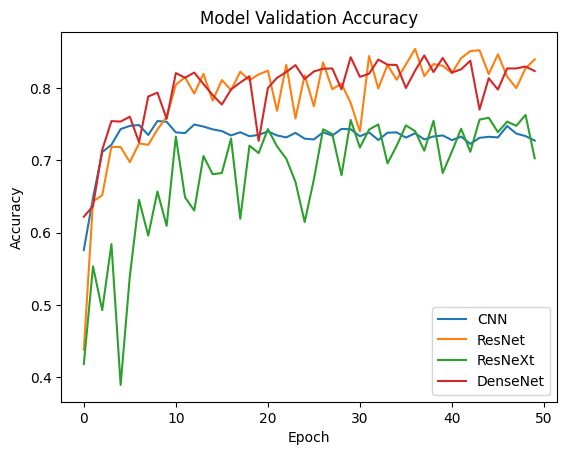

In [ ]:
# Plotting
plt.plot(history_cnn.history['val_accuracy'], label='CNN')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet')
plt.plot(history_resnext.history['val_accuracy'], label='ResNeXt')
plt.plot(history_densenet.history['val_accuracy'], label='DenseNet')
plt.title('Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Plotting
plt.plot(history_cnn.history['accuracy'], label='CNN')
plt.plot(history_resnet.history['accuracy'], label='ResNet')
plt.plot(history_resnext.history['accuracy'], label='ResNeXt')
plt.plot(history_densenet.history['accuracy'], label='DenseNet')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: ignored

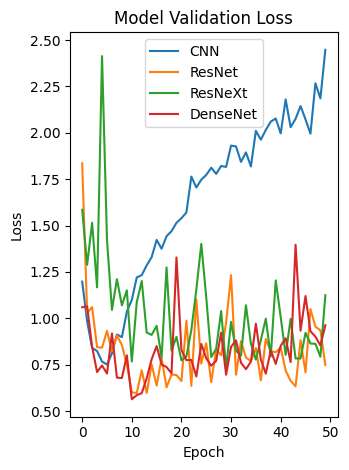

In [ ]:
# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['val_loss'], label='CNN')
plt.plot(history_resnet.history['val_loss'], label='ResNet')
plt.plot(history_resnext.history['val_loss'], label='ResNeXt')
plt.plot(history_densenet.history['val_loss'], label='DenseNet')
plt.title('Model Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


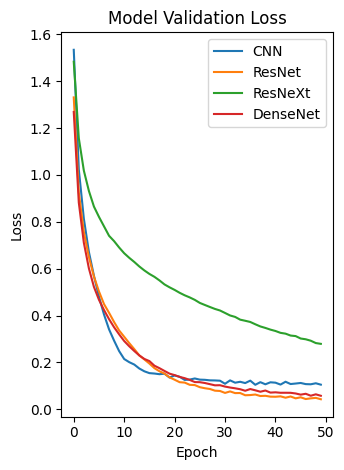

In [ ]:
# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='CNN')
plt.plot(history_resnet.history['loss'], label='ResNet')
plt.plot(history_resnext.history['loss'], label='ResNeXt')
plt.plot(history_densenet.history['loss'], label='DenseNet')
plt.title('Model Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()